<a href="https://colab.research.google.com/github/2403a52029-lab/NLP_LAB-ASSIGNMENTS/blob/main/Lab12_4_TextCNN_PretrainedEmbeddings_J_NithinPatil_2403A52029.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torchtext


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.2 MB/s eta 0:00:00


In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [13]:
# Load dataset
df = pd.read_csv('/content/SMSSpamCollection', sep='\t', header=None)
df.columns = ['label', 'message']

print(df.head())
print("Total Samples:", len(df))
print("Classes:", df['label'].unique())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Total Samples: 5572
Classes: ['ham' 'spam']


In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['message'] = df['message'].apply(clean_text)

# Convert labels to numbers
df['label'] = df['label'].map({'ham':0, 'spam':1})


In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2026-02-19 04:15:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-19 04:15:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-19 04:15:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [17]:
from collections import Counter

tokenized = [msg.split() for msg in df['message']]
vocab = Counter()

for tokens in tokenized:
    vocab.update(tokens)

word2idx = {word:i+2 for i,(word,_) in enumerate(vocab.items())}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1


In [18]:
embedding_dim = 100
embeddings_index = {}

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, i in word2idx.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


In [7]:
max_len = 50

def encode(text):
    tokens = text.split()
    encoded = [word2idx.get(word,1) for word in tokens]
    if len(encoded) < max_len:
        encoded += [0]*(max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df['encoded'] = df['message'].apply(encode)

X = np.array(df['encoded'].tolist())
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # freeze embeddings

        self.conv = nn.Conv1d(embedding_dim, 100, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(2400, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1)
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.sigmoid(x)

model = TextCNN(len(word2idx), embedding_dim, embedding_matrix)


In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_data = torch.tensor(X_train, dtype=torch.long)
train_labels = torch.tensor(y_train, dtype=torch.float32)

epochs = 5

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_data).squeeze()
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.7058554291725159
Epoch 2, Loss: 0.6101545691490173
Epoch 3, Loss: 0.5433881282806396
Epoch 4, Loss: 0.49727562069892883
Epoch 5, Loss: 0.46660900115966797


In [10]:
test_data = torch.tensor(X_test, dtype=torch.long)
preds = model(test_data).detach().numpy()
preds = (preds > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Accuracy: 0.8663677130044843

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

Confusion Matrix:
 [[966   0]
 [149   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_data = torch.tensor(X_train, dtype=torch.long)
train_labels = torch.tensor(y_train, dtype=torch.float32)

epochs = 5
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_data).squeeze()
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.44626736640930176
Epoch 2, Loss: 0.41345226764678955
Epoch 3, Loss: 0.3835400342941284
Epoch 4, Loss: 0.35639825463294983
Epoch 5, Loss: 0.3319706618785858


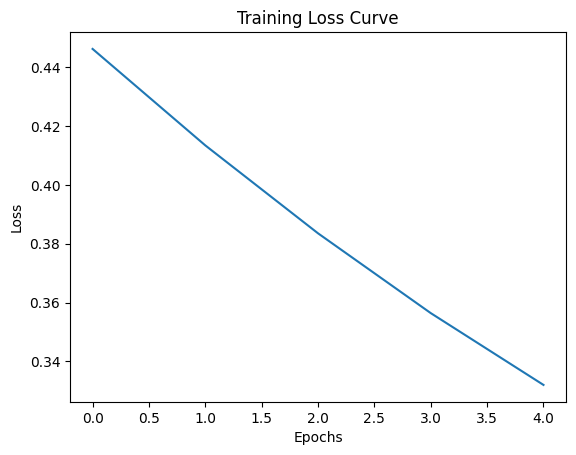

In [20]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


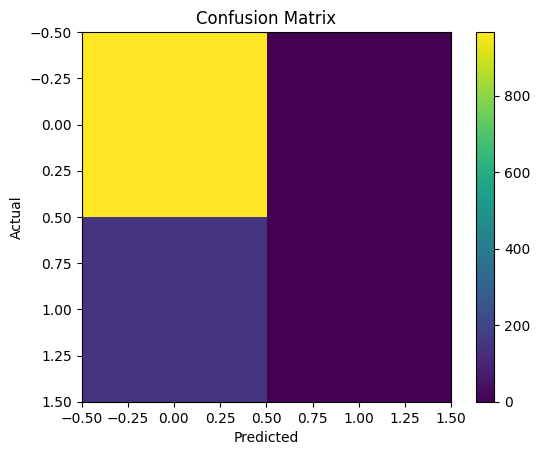

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_data = torch.tensor(X_test, dtype=torch.long)
preds = model(test_data).detach().numpy()
preds = (preds > 0.5).astype(int)

cm = confusion_matrix(y_test, preds)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()


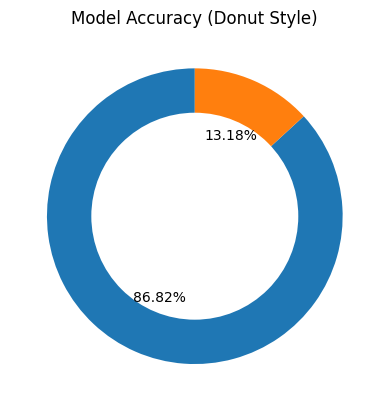

In [27]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, preds)

plt.figure()

# Create data for donut chart
sizes = [accuracy, 1 - accuracy]

plt.pie(sizes, startangle=90, autopct='%1.2f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Model Accuracy (Donut Style)")
plt.show()


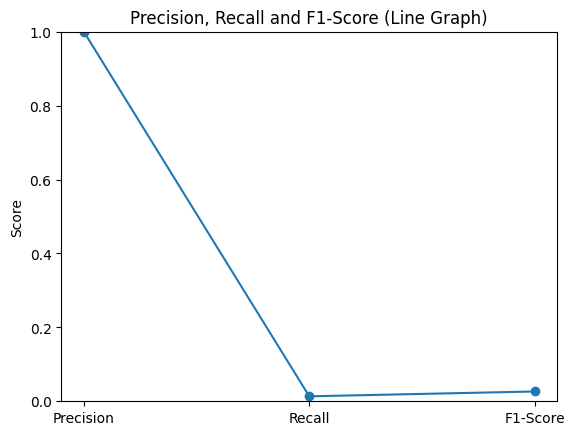

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

metrics = [precision, recall, f1]
labels = ["Precision", "Recall", "F1-Score"]

plt.figure()
plt.plot(labels, metrics, marker='o')
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Precision, Recall and F1-Score (Line Graph)")
plt.show()
